# Project 3 titanic survival prediction

### Import library

In [531]:
library(tidyverse)
library(magrittr)
library(stringr)
library("e1071")
library(CatEncoders)
library(onehot)

### 1. 處理 'boat' 欄

In [543]:
# read data and filter out those 'survived' are NA
titanicTrain = read_csv("titanicTrain.csv")
titanicTrain.surv.nona <- filter(titanicTrain, !is.na(survived))
titanicTrain.surv.withna <- titanicTrain

Parsed with column specification:
cols(
  pclass = col_integer(),
  survived = col_integer(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


In [534]:
# is.boat is powerful!
titanicTrain.surv.nona %>% mutate(is.boat = !is.na(boat)) %>% 
  group_by(is.boat,survived) %<>% summarise(m=n())%>% mutate(ratio = paste0(round(m/(569+14+8+409)*100, 2), "%"))

is.boat,survived,m,ratio
FALSE,0,569,56.9%
FALSE,1,14,1.4%
TRUE,0,8,0.8%
TRUE,1,409,40.9%


In [535]:
titanicTrain.surv.withna %>% mutate(is.boat = !is.na(boat)) %>% 
  group_by(is.boat,survived) %<>% summarise(m=n()) %>% mutate(ratio = paste0(round(m/(569+14+310+8+409)*100, 2), "%"))

is.boat,survived,m,ratio
FALSE,0,569,43.44%
FALSE,1,14,1.07%
FALSE,NA,310,23.66%
TRUE,0,8,0.61%
TRUE,1,409,31.22%


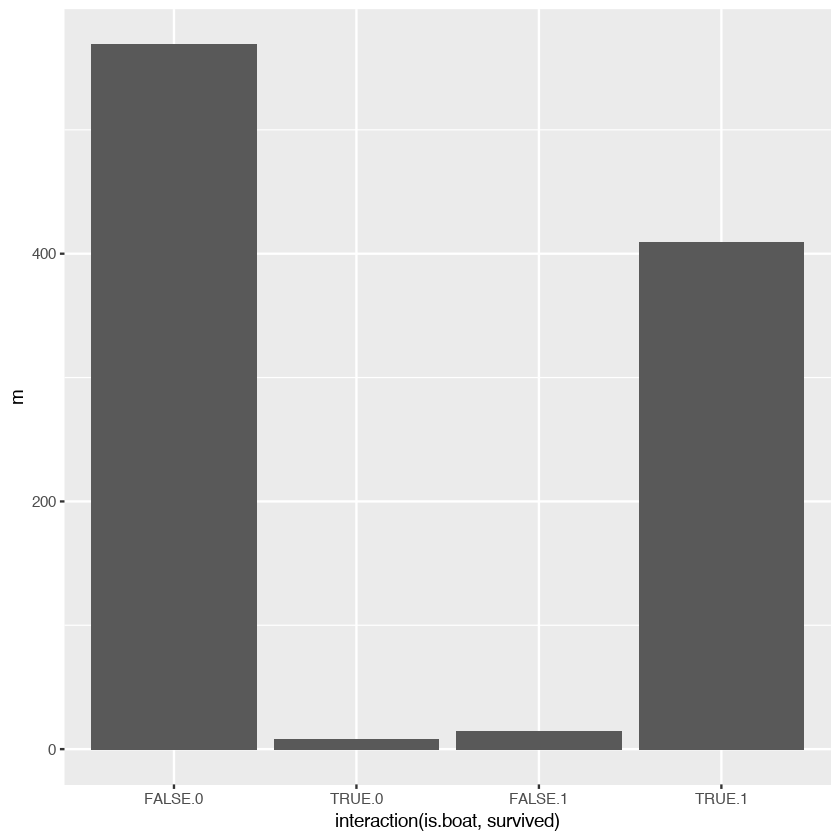

In [536]:
# whether is on the boat is a dominant factor.
titanicTrain.surv.nona %>% mutate(is.boat = !is.na(boat)) %>% 
  group_by(is.boat,survived) %>% summarise(m=n()) %>% 
  ggplot(mapping = aes(interaction(is.boat,survived),m)) + geom_col()

由上述結果可以看出是否上救生艇與是否生存具有決定性的影響因素。以是否上船為基準來預測是否生存（去除survived缺乏資料者），可發現預測錯誤率僅為 2.2%，準確率極高，基本上可以直接以使否上船來做為是否生存的預測模型。

此外我們發現，沒有上船的，有310個人的survived 缺乏資料，或許是因為失蹤。不過單就「**預測上船者是存活的**」而言，預測的正確率為98.1%

### 2.處理 'sex' ＊ 'pclass'

In [537]:
# sex * pclass is powerful too 
titanicTrain.surv.withna %>% transform(survived = as.factor(survived)) %>% 
  group_by(pclass,sex,survived) %>% 
  ggplot(mapping = aes(interaction(pclass,sex),fill = survived)) + geom_bar()

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘transform’ for signature ‘"tbl_df"’


Warning message:
“Removed 1 rows containing missing values (position_stack).”

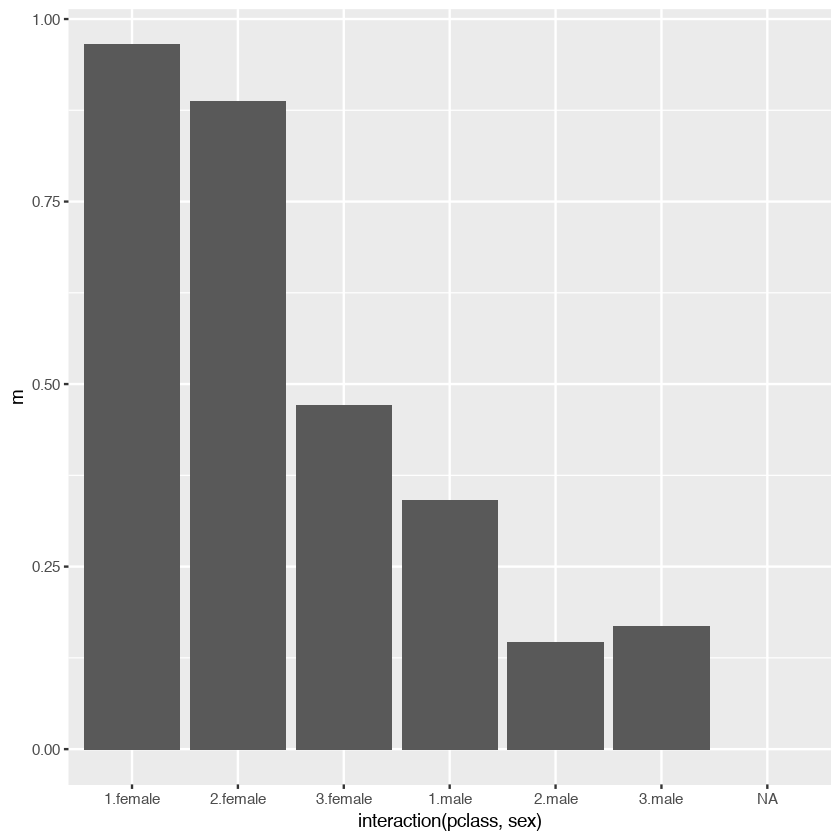

In [538]:
titanicTrain.surv.withna %>% 
  group_by(pclass,sex) %>% summarise(m = sum(survived)/length(survived)) %>% 
  ggplot(mapping = aes(interaction(pclass,sex),m)) + geom_col()

如果以性別以及艙等來預測是否生存，我們可以發現，女性頭等艙的預測準確率最高，隨著艙等的下降，期預測率開始下降。男性則是預測準確度皆低於37.5%

### 3. nGroup

In [539]:
# considering ticket
ticket.group = titanicTrain %>% group_by(ticket) %>% summarise(ticket.group=n())
titanicTrain %<>% left_join(ticket.group)

Joining, by = "ticket"


In [544]:
# considering first name
name.group = titanicTrain %>% group_by(name.first) %>% summarise(name.group=n())
titanicTrain %<>% left_join(name.group)

ERROR: Error in grouped_df_impl(data, unname(vars), drop): Column `name.first` is unknown


In [547]:
# considering 
home.group = titanicTrain %>% filter((ticket.group != 1)&(ticket.group != name.group)) %>% 
  group_by(ticket,home.dest) %>% summarise(home.group=n())
titanicTrain %<>% left_join(home.group)

ERROR: Error in filter_impl(.data, quo): Evaluation error: ‘!=’ only defined for equally-sized data frames.


In [548]:
# generate ngroup
titanicTrain$index = 1:nrow(titanicTrain)
df1 = titanicTrain %>% filter(ticket.group == name.group) %>% 
  mutate(ngroup = ticket.group) %>% select(index,ngroup)

df2 = titanicTrain %>% filter(ticket.group == home.group) %>% 
  mutate(ngroup = ticket.group) %>% select(index,ngroup)

df3 = titanicTrain %>% filter((ticket.group != home.group)&(name.group == home.group)) %>% 
  mutate(ngroup = name.group) %>% select(index,ngroup)

df4 = df1 %>% full_join(df2) %>% full_join(df3)
 
titanicTrain %<>% left_join(df4)
titanicTrain %>% View

ERROR: Error in filter_impl(.data, quo): Evaluation error: ‘==’ only defined for equally-sized data frames.


In [549]:
# test ngroup
titanicTrain %>% filter(!is.na(ngroup)) %>% 
  group_by(ngroup,survived) %>% summarise(m=n()) %>% 
  ggplot(mapping = aes(ngroup,m,fill = survived)) + geom_col()

titanicTrain %>% filter(!is.na(ngroup)) %>% 
  group_by(ngroup) %>% summarise(m=sum(survived)/length(ngroup)) %>% 
  ggplot(mapping = aes(ngroup,m)) + geom_col()

ERROR: Error in filter_impl(.data, quo): Evaluation error: 找不到物件 'ngroup'.


# Explore ML model

### 首先先整理資料

In [550]:
# drop rows that is all nan
titanicTrain.row.no.na <- titanicTrain.surv.withna[rowSums(is.na(titanicTrain.surv.withna)) != ncol(titanicTrain.surv.withna),]

In [551]:
# add a column with first_name
titanicTrain.row.no.na["first_name"] <- str_split_fixed(titanicTrain.row.no.na$name, ',', 3)[,1]

In [552]:
# fill nan with default values
titanicTrain.row.no.na$age[is.na(titanicTrain.row.no.na$age)] <- '0'
titanicTrain.row.no.na$cabin[is.na(titanicTrain.row.no.na$cabin)]  <- 'nan'
titanicTrain.row.no.na$embarked[is.na(titanicTrain.row.no.na$embarked)]  <- 'nan'
titanicTrain.row.no.na$boat[is.na(titanicTrain.row.no.na$boat)]  <- 'nan'
titanicTrain.row.no.na$body[is.na(titanicTrain.row.no.na$body)]  <- '0'

In [553]:
titanicTrain.final <- titanicTrain.row.no.na[,c("pclass", "survived", "first_name", "sex", "age", "sibsp", "parch", "ticket", "fare", "cabin", "embarked", "boat", "body")]

In [554]:
head(titanicTrain.final,10)

pclass,survived,first_name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
1,1,Allen,female,29,0,0,24160,211.3375,B5,S,2,0
1,1,Allison,male,0.9167,1,2,113781,151.5500,C22 C26,S,11,0
1,0,Allison,female,2,1,2,113781,151.5500,C22 C26,S,nan,0
1,0,Allison,male,30,1,2,113781,151.5500,C22 C26,S,nan,135
1,0,Allison,female,25,1,2,113781,151.5500,C22 C26,S,nan,0
1,1,Anderson,male,48,0,0,19952,26.5500,E12,S,3,0
1,1,Andrews,female,63,1,0,13502,77.9583,D7,S,10,0
1,0,Andrews,male,39,0,0,112050,0.0000,A36,S,nan,0
1,1,Appleton,female,53,2,0,11769,51.4792,C101,S,D,0
1,0,Artagaveytia,male,71,0,0,PC 17609,49.5042,nan,C,nan,22


In [555]:
titanicQestion <- read_csv("titanicQuestion.csv")

# drop rows that is all nan
titanicQestion <- titanicQestion[rowSums(is.na(titanicQestion)) != ncol(titanicQestion),]

# add a column with first_name
titanicQestion["first_name"] <- str_split_fixed(titanicQestion$name, ',', 3)[,1]
# fill nan with default values
titanicQestion$age[is.na(titanicQestion$age)] <- '0'
titanicQestion$cabin[is.na(titanicQestion$cabin)]  <- 'nan'
titanicQestion$embarked[is.na(titanicQestion$embarked)]  <- 'nan'
titanicQestion$boat[is.na(titanicQestion$boat)]  <- 'nan'
titanicQestion$body[is.na(titanicQestion$body)]  <- '0'

titanicQestion.final <- titanicQestion[,c("pclass", "survived", "first_name", "sex", "age", "sibsp", "parch", "ticket", "fare", "cabin", "embarked", "boat", "body")]

Parsed with column specification:
cols(
  pclass = col_integer(),
  survived = col_character(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


In [556]:
head(titanicQestion.final, 10)

pclass,survived,first_name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
3,NA,McCormack,male,0,0,0,367228,7.7500,nan,Q,nan,0
3,NA,McCoy,female,0,2,0,367226,23.2500,nan,Q,16,0
3,NA,McCoy,female,0,2,0,367226,23.2500,nan,Q,16,0
3,NA,McCoy,male,0,2,0,367226,23.2500,nan,Q,16,0
3,NA,McDermott,female,0,0,0,330932,7.7875,nan,Q,13,0
3,NA,McEvoy,male,0,0,0,36568,15.5000,nan,Q,nan,0
3,NA,McGovern,female,0,0,0,330931,7.8792,nan,Q,13,0
3,NA,McGowan,female,15,0,0,330923,8.0292,nan,Q,nan,0
3,NA,McGowan,female,35,0,0,9232,7.7500,nan,Q,nan,0
3,NA,McMahon,male,0,0,0,370372,7.7500,nan,Q,nan,0


In [557]:
# answer (Y in training set)
Y <- titanicTrain.final$survived

In [558]:
# drop survived
data <- titanicTrain.final[,!(names(titanicTrain.final) %in% c("survived"))]
test_data <- titanicQestion.final[,!(names(titanicQestion.final) %in% c("survived"))]

In [559]:
# data encoding
data$first_name <- as.integer(as.factor(data$first_name))
data$sex <- as.integer(as.factor(data$sex))
data$ticket <- as.integer(as.factor(data$ticket))
data$cabin <- as.integer(as.factor(data$cabin))
data$embarked <- as.integer(as.factor(data$embarked))
data$boat <- as.integer(as.factor(data$boat))
data$body <- as.integer(as.factor(data$body))

In [560]:
# test_data encoding
test_data$first_name <- as.integer(as.factor(test_data$first_name))
test_data$sex <- as.integer(as.factor(test_data$sex))
test_data$ticket <- as.integer(as.factor(test_data$ticket))
test_data$cabin <- as.integer(as.factor(test_data$cabin))
test_data$embarked <- as.integer(as.factor(test_data$embarked))
test_data$boat <- as.integer(as.factor(test_data$boat))
test_data$body <- as.integer(as.factor(test_data$body))